In [34]:
import alg
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import dalex as dx

df = pd.read_csv("data/heart.csv")

RENAME_DICT = {"thalach": "maximum heart rate",
               "trestbps": "resting blood pressure",
               "chol": "serum cholesterol"}
VARIABLES = {
    'age', 'sex', 'cp', RENAME_DICT['trestbps'], RENAME_DICT['chol'],
    'fbs', 'restecg', RENAME_DICT['thalach'], 'exang', 'oldpeak',
    'slope',  'ca', 'thal'
}
VARIABLES_TO_CHANGE = ['age', RENAME_DICT['thalach'], RENAME_DICT['trestbps'], RENAME_DICT['chol'], 'oldpeak']
CONSTANT = VARIABLES.difference(VARIABLES_TO_CHANGE)

df.rename(columns=RENAME_DICT, inplace=True)

X, y = df.drop("target", axis=1).loc[:, ["sex"] + VARIABLES_TO_CHANGE], df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

model = xgboost.XGBClassifier(n_estimators=100, max_depth=4, random_state=0, use_label_encoder=False, eval_metric="logloss").fit(X_train, y_train)
explainer = alg.Explainer(model, X_test)
import dalex as dx
e = dx.Explainer(model, X_test, y_test, verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.740741,0.8,0.769231,0.76,0.750805


In [35]:
pd.DataFrame({'variable': X.columns, 'importance_split': model.feature_importances_,
              'importance_shap': explainer.shap_values(explainer.data),
              'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})

,variable,importance_split,importance_shap,importance_perm
2,sex,0.174695,0.098787,0.257343
6,age,0.130303,0.072169,0.315153
5,maximum heart rate,0.187555,0.165937,0.301433
0,resting blood pressure,0.112525,0.048233,0.244734
3,serum cholesterol,0.093069,0.086906,0.264831
4,oldpeak,0.301852,0.175669,0.287069


In [43]:
I = 7
a = alg.GeneticAlgorithm(explainer, constant=["sex"], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,sex,age,maximum heart rate,resting blood pressure,serum cholesterol,oldpeak,y,y_hat
193,1,60,142,145,282,2.8,0,0.000941


In [44]:
a = alg.GeneticAlgorithm(explainer, constant=["sex"], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X, a._x)
t = np.array([i + (t[0] / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X, a._x), 'target': t})

,variable,shap_values,target
0,sex,-0.052349,-0.005000
1,age,-0.055981,-0.038532
2,maximum heart rate,-0.066172,-0.048723
3,resting blood pressure,-0.029580,-0.012130
4,serum cholesterol,-0.153509,-0.136060
5,oldpeak,-0.149321,-0.131871


In [38]:
a.fool_aim(target=t, max_iter=500, random_state=0)

Iter: 500 || Loss: 0.17147226899402765: 100%|██████████| 500/500 [1:07:57<00:00,  8.15s/it]


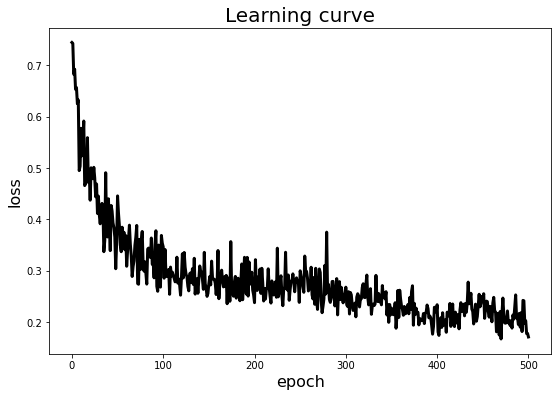

In [39]:
a.plot_losses()

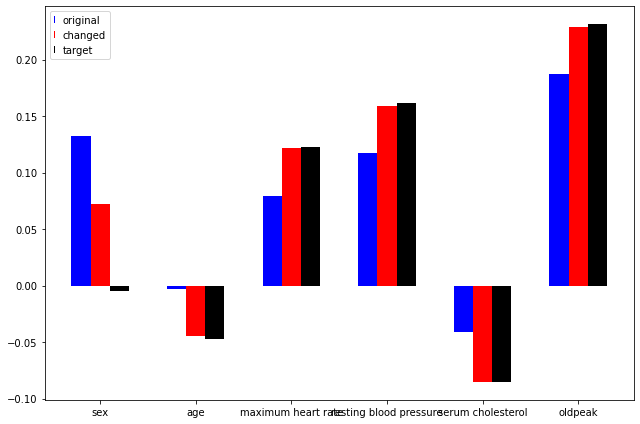

In [40]:
a.plot_explanation()

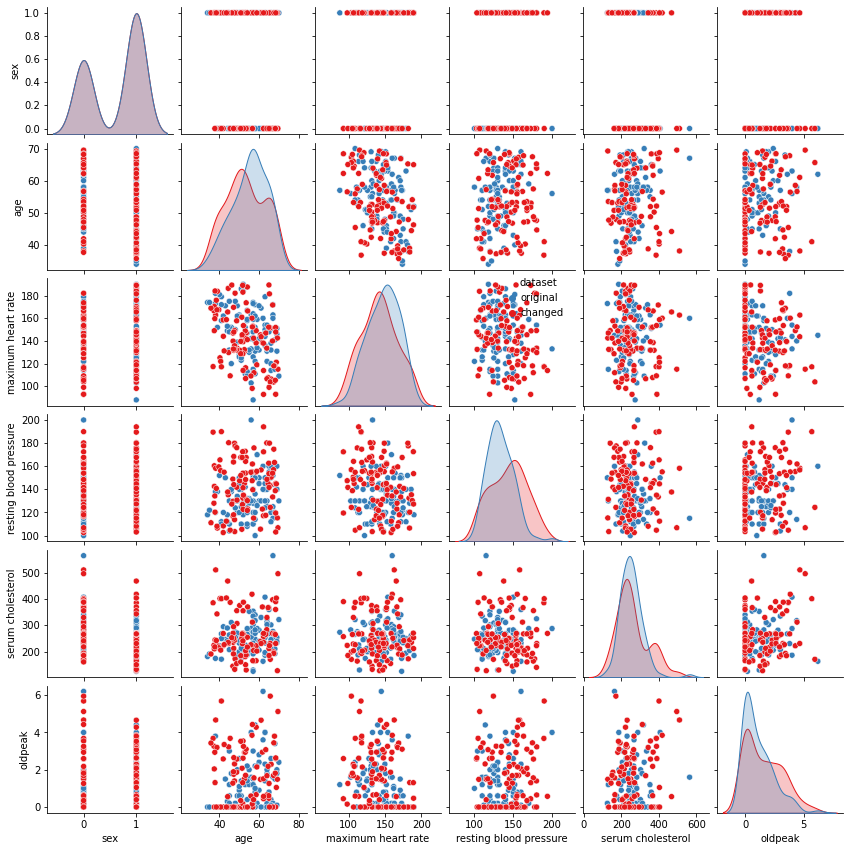

In [41]:
a.plot_data()

In [42]:
import pickle
pickle.dump(a.result_explanation, open("results/final-heart-local_explanation.p", "wb") )
pickle.dump(a.result_data, open("results/final-heart-local_data.p", "wb" ) )
pickle.dump(a.iter_losses, open("results/final-heart-local_losses.p", "wb") )